In [1]:
%load_ext autoreload

%autoreload 2
from multiprocessing import Pool
import matplotlib.pyplot as plt
import pickle
from astropy.coordinates import SkyCoord, match_coordinates_3d, match_coordinates_sky
import sys
import emcee
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack, vstack
from astropy import units as u
import corner
from astropy.coordinates import SkyCoord, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value

sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/')
#import CL_WL_miscentering as mis
import analysis_Mass_Richness_relation as analysis
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_DATAOPS_match_catalogs as match
import CL_WL_DATAOPS_make_profile as prf
import CL_Likelihood_for_Mass_richness_relation as likelihood_mr
#import CL_fiducial_mass_richness_relation as fiducial
#import analysis_Mass_richness_relation as analysis
import CL_Mass_richness_relation as mr

sys.path.append('/pbs/throng/lsst/users/cpayerne/CLCosmo_Sim/cluster_abundance')
import CL_COUNT_modeling_completeness as comp
import CL_COUNT_modeling_purity as pur
import CL_COUNT_modeling_halo_mass_function as hmf
import CL_MASS_cluster_mass as cl_mass
import CL_COUNT_modeling_richness_mass_relation as rm_relation

import CL_COUNT_cluster_abundance as cl_count
import CL_LENSING_cluster_lensing as cl_lensing

import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
import astropy.units as un
from clmm import Cosmology
from clmm.support import mock_data as mock
import pyccl as ccl

cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

In [2]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

In [3]:
data = np.load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/notebooks/data_for_notebooks/stacked_esd_profiles_redmapper_true.pkl', allow_pickle=True)

In [4]:
Z_bin = analysis.Z_bin
Obs_bin = analysis.Obs_bin

# From stacked masses

In [5]:
MR_modeling = mr.WL_Mass_Richness()
MR_modeling.set_pivot_values(analysis.z0, analysis.richness0)
profiles = data['stacked profile']
covariances = data['stacked covariance']

#modeling of the unitary excess surface density profile
def esd_modeling(R, log10m, c, z, cosmo, halo_profile = 'nfw'):
    return clmm.compute_excess_surface_density(R, 10**log10m, c, z, cosmo, delta_mdef=200,
                                       halo_profile_model=halo_profile, massdef='critical')
#radius_th = lnL.radius

In [6]:
M = np.load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/notebooks/plots/WL_mean_masses/halomodel_nfw_freec.pkl', allow_pickle=True)

In [7]:
log10M = np.array(M['masses']['log10M200c_WL'])
c = np.array(M['masses']['c_w'])
richness = np.array(M['masses']['obs_mean'])
z = np.array(M['masses']['z_mean'])

# From DS

In [8]:
R = np.array([0.55714842, 0.6804306 , 0.83032523, 1.01419232, 1.23822211,
       1.51217248, 1.84672312, 2.25518907, 2.75257284, 3.3614032 ,
       4.10456528, 5.01139196, 6.11925852, 7.47073947, 9.12433179])
DS = np.load('/pbs/throng/lsst/users/cpayerne/CLCosmo_Sim/richness_mass_from_DC2/best_fit_DS.npy',)

7 4
140
73
14
6
252
104
13
6
300
137
17
17
354
122
19
12
367
153
31
14
304
139
21
7
650
288
32
22


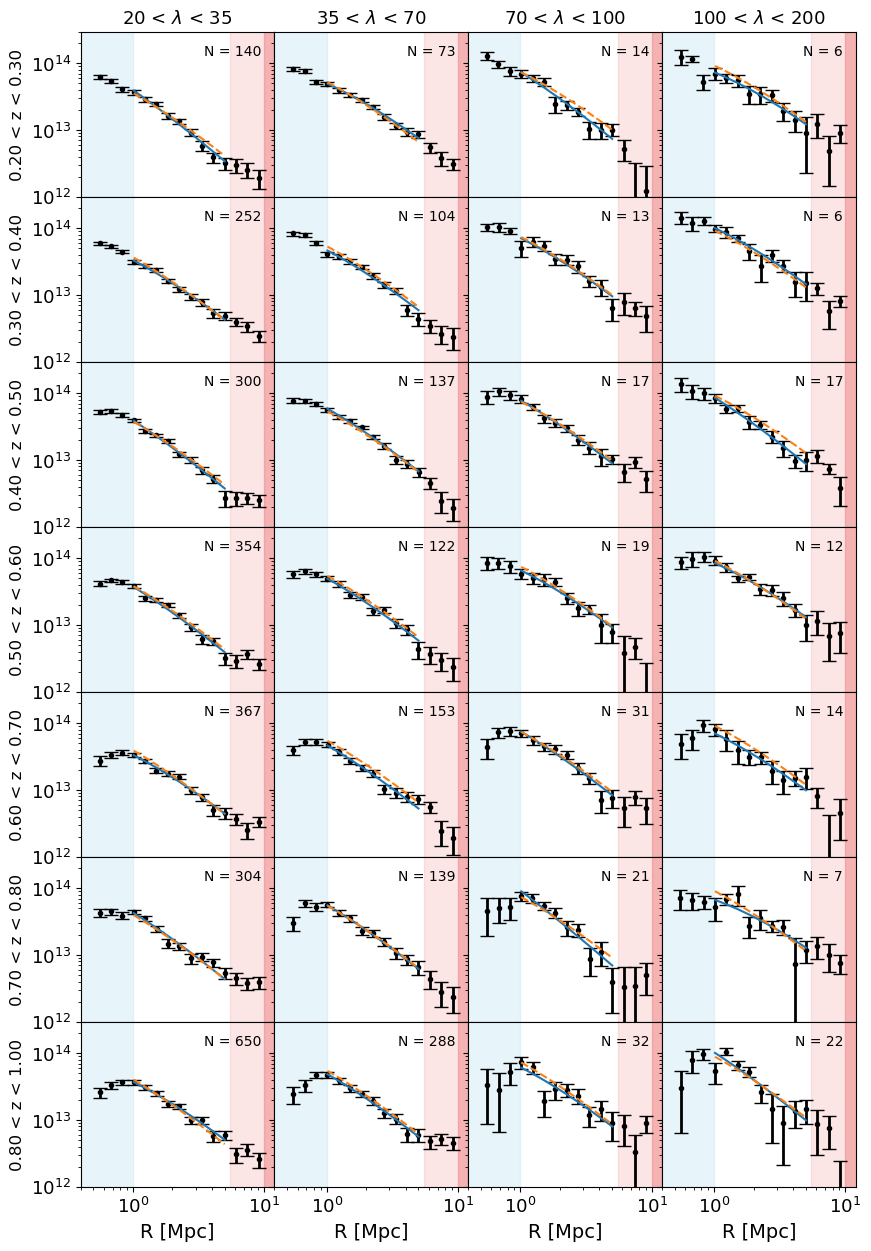

In [9]:
n_z_bin = len(Z_bin) 
n_m_bin = len(Obs_bin) 
print(n_z_bin, n_m_bin)
scale = 4
fig, axs = plt.subplots( n_z_bin, n_m_bin, figsize = (10,15))
fig.subplots_adjust(wspace=0, hspace=0)
for i, z_bin in enumerate(Z_bin):

    for j, m_bin in enumerate(Obs_bin):
            #try:

            #if i >= n_m_bin: continue
            
            label_z =   f'{z_bin[0]:.2f} < z < {z_bin[1]:.2f}'
            label_M = f'{m_bin[0]:.0f} < ' + r'$\lambda$' +f' < {m_bin[1]:.0f}'
            mask_z = (profiles['z_mean'] > z_bin[0])*(profiles['z_mean'] < z_bin[1])
            mask_m = (profiles['obs_mean'] > m_bin[0])*(profiles['obs_mean'] < m_bin[1])
            index = np.arange(len(profiles))
            index_cut = index[mask_m * mask_z]
            f_cut = profiles[index_cut]
            cov = np.array(covariances['cov_t'][index_cut])
            err = cov.T.diagonal()**.5
            axs[i, j].errorbar(f_cut['radius'][0], f_cut['gt'][0] , err[0],
                                c = 'k'
                               ,marker = 'o',fmt = ' ', elinewidth = 2, capsize = 5, markersize = 3, markerfacecolor = None)
            #stacked mass
            maskr = (richness > m_bin[0])*(richness < m_bin[1])
            maskz = (z > z_bin[0])*(z < z_bin[1])
            r = np.linspace(1, 5.5, 10)
            mask = (R > 1)*(R < 5.5)
            axs[i,j].plot(R[mask], esd_modeling(R[mask], log10M[maskz*maskr][0], c[maskz*maskr][0], z[maskz*maskr][0], cosmo_clmm, halo_profile = 'nfw'), zorder=1000)
            axs[i,j].plot(R[mask], DS[:,j,i][mask], '--', zorder=10000)
            #ds_th = np.array(ds)[index_cut][0]
            #axs[i, j].loglog(radius_th, ds_th, 'r', zorder=1000)
            #ds_th = np.array(dstrue)[index_cut][0]
            #axs[i, j].loglog(radius_th, ds_th, 'b', zorder=1000)
            #axs[i, j].plot(f_cut['radius'][0], ds[index_cut])
            
            #r=np.linspace(1, 5.5, 100)
            #lnM = MR_modeling.lnM(f_cut['obs_mean'][0], f_cut['z_mean'][0], [14.13190028, -0.71776671,  0.7400713 ])
            #print(lnM)
            #y = clmm.compute_excess_surface_density(r, np.exp(lnM), 4, f_cut['z_mean'][0], cosmo, delta_mdef=200,
            #                               halo_profile_model='nfw', massdef='critical')  
            n = len(f_cut['z_individual'][0])
            print(n)
            axs[i,j].plot([], [], color = 'w', label = f'N = {n:.0f}')
            radius = np.linspace(0, 1, 100)
            axs[i, j].fill_between(radius, 0*radius + 1e16, alpha = .2, color = 'skyblue')# + 1e16)
            radius = np.linspace(5.5, 20, 100)
            axs[i, j].fill_between(radius, 0*radius + 1e16, alpha = .2, color = 'lightcoral')# + 1e16)
            radius = np.linspace(10, 20, 100)
            axs[i, j].fill_between(radius, 0*radius + 1e16,alpha = .5,color='lightcoral',)
            axs[i, j].set_ylim(1e12, 3e14)
            axs[i, j].set_xlim(0.4, 12)
            axs[i, j].set_xscale('log')
            axs[i, j].set_yscale('log')
            axs[i, j].tick_params(axis='both', which = 'major', labelsize= 13)
            axs[i, j].legend(frameon = False, loc = 'upper right', fontsize = 10)
            axs[i, j].set_xlabel('R [Mpc]', fontsize = 14)
            axs[i, 0].set_ylabel(label_z, fontsize = 12)
            axs[0, j].set_title(label_M, fontsize = 13)
        #except: a=1

for ax in fig.get_axes():
    ax.label_outer()
plt.savefig('redmapper_profiles.png', bbox_inches='tight', dpi=300)